In [34]:
import numpy as np
import os, sys
sys.path.insert(0,os.getcwd())
sys.path.insert(0,os.path.dirname(os.getcwd()))
import isi_corr
import dnn_dist
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [21]:
def get_matches(mt, mt_path, rec1, rec2, dnn_metric="DNNSim", um_metric="MatchProb", dist_thresh=None):
    mt = mt.loc[(mt["RecSes1"].isin([rec1,rec2])) & (mt["RecSes2"].isin([rec1,rec2])),:]
    if len(mt) < 20:
        return None, None
    try:
        thresh = dnn_dist.get_threshold(mt, metric=dnn_metric, vis=False)
    except:
        return None, None
    if um_metric=="MatchProb":
        thresh_um=0.5
    else:
        if um_metric=="ScoreExclCentroid":
            col = mt.loc[:, "WavformSim":"LocTrajectorySim"]
            mt[um_metric] = col.mean(axis=1)
        thresh_um = dnn_dist.get_threshold(mt, metric=um_metric, vis=False)
    within = mt.loc[(mt["RecSes1"]==mt["RecSes2"]), [dnn_metric, "ISICorr", "ID1", "ID2", um_metric]]                                              # Only keep within-day bits
    across = mt.loc[(mt["RecSes1"]!=mt["RecSes2"]), [dnn_metric, "ISICorr", um_metric, "RecSes1", "RecSes2", "ID1", "ID2"]]                        # Only keep across-day bits

    # Correct for different median similarities between within- and across-day sets.
    diff = np.median(within[dnn_metric]) - np.median(across[dnn_metric])
    thresh = thresh - diff

    diff_um = np.median(within[um_metric]) - np.median(across[um_metric])
    thresh_um = thresh_um - diff_um

    matches_across = across.loc[mt[dnn_metric]>=thresh, ["ISICorr", "RecSes1", "RecSes2", "ID1", "ID2"]]
    um_matches = across.loc[mt[um_metric]>=thresh_um, ["ISICorr", "RecSes1", "RecSes2", "ID1", "ID2"]]
    if len(matches_across)==0:
        print("no DNN matches found!")
        return None, None
    matches_across = isi_corr.spatial_filter(mt_path, matches_across, dist_thresh, plot_drift=False)
    return matches_across, um_matches


test_data_root = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "R_DATA_UnitMatch")
mt_path = os.path.join(test_data_root, "AL036", "19011116882", "3", "new_matchtable.csv") 
dnn_matches, um_matches = get_matches(mt_path, 4,5)

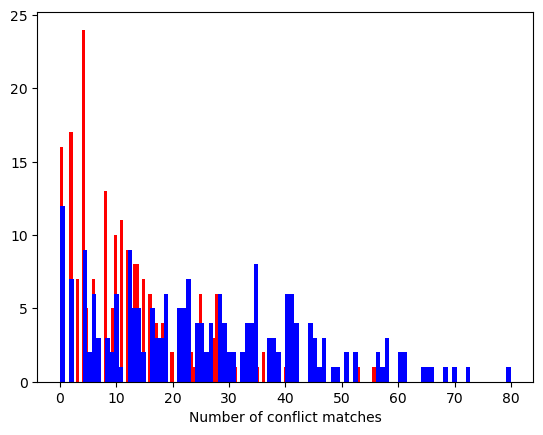

In [33]:
def conflicts(matches):
    conflicts = []
    for idx, match in matches.iterrows():
        id1 = match["ID1"]
        id2 = match["ID2"]
        r1 = match["RecSes1"]
        r2 = match["RecSes2"]

        neuron1=matches.loc[(matches["ID1"]==id1) & (matches["RecSes1"]==r1),:]
        if len(neuron1)>1:
            conflicts.append((r1,id1,r2,id2))
        
        neuron2=matches.loc[(matches["ID2"]==id2) & (matches["RecSes2"]==r2),:]
        if len(neuron2)>1:
            conflicts.append((r1,id1,r2,id2))
    return set(conflicts)

mt = pd.read_csv(mt_path)
sessions = set(mt["RecSes1"].unique())

conflict_matches_dnn = []
conflict_matches_um = []
for r1 in sessions:
    for r2 in sessions:
        if r1>=r2:
            continue
        dnn_matches, um_matches = get_matches(mt, mt_path, r1, r2)
        conflict_matches_dnn.append(len(conflicts(dnn_matches)))
        conflict_matches_um.append(len(conflicts(um_matches)))
plt.hist(conflict_matches_dnn, bins = 100, label="DNN", color="r")
plt.hist(conflict_matches_um, bins = 100, label="UM", color="b")
plt.xlabel("Number of conflict matches")
plt.show()